# Hourly Time Series Forecasting using Facebook's Prophet


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.
 
Pulling the [PJM East](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJME_hourly.csv) which has data from 2002-2018 for the entire east region.
 

In [8]:
pjme = pd.read_csv('../input/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


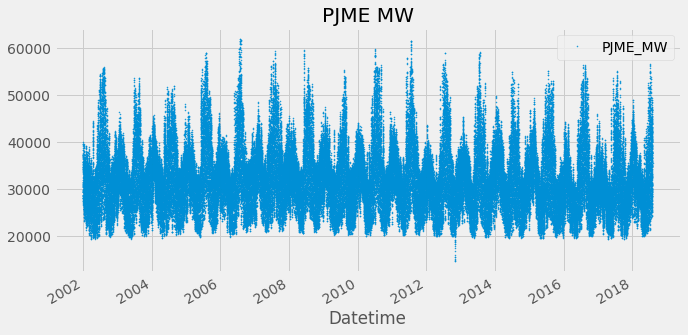

In [9]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Outlier Analysis and removal

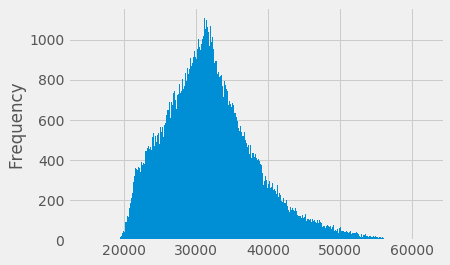

In [10]:
pjme['PJME_MW'].plot(kind='hist', bins=500)

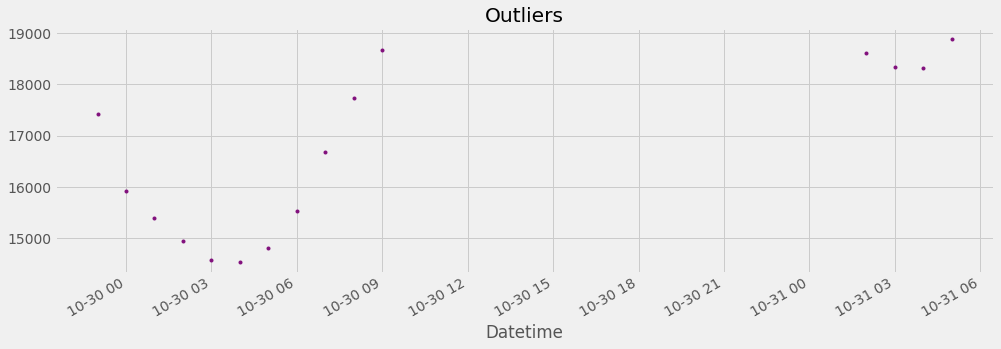

In [11]:
pjme.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [13]:
pjme = pjme.query('PJME_MW > 19_000').copy()

# Time Series Features

In [14]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

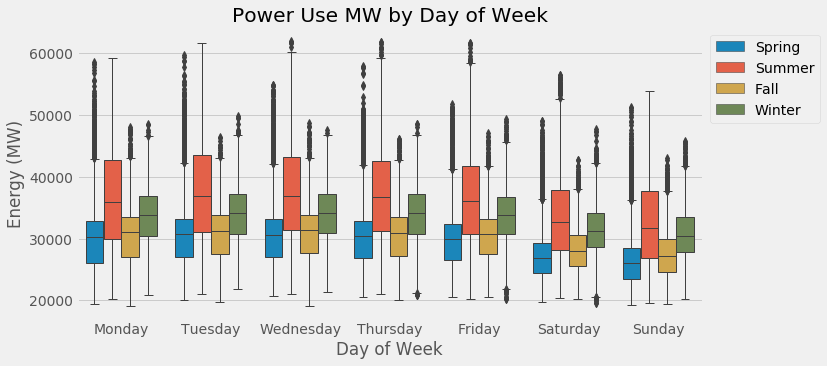

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [22]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# Train / Test Split

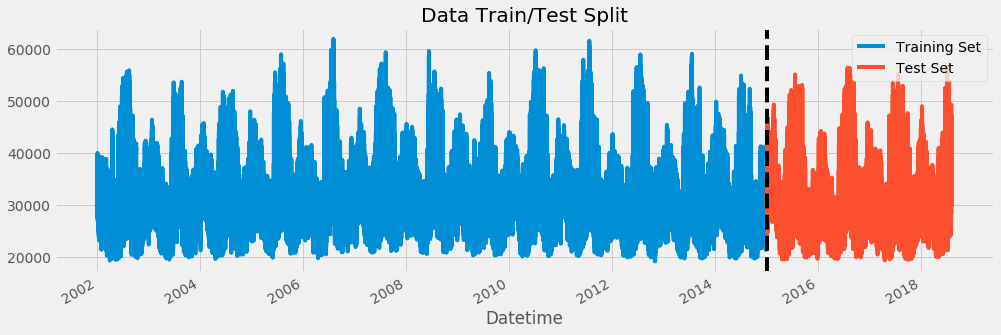

In [23]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split

fig, ax = plt.subplots(figsize=(15, 5))
pjme_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
pjme_test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [24]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [25]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

CPU times: user 4min 32s, sys: 866 ms, total: 4min 33s
Wall time: 4min 32s


In [26]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [27]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31213.696721,23870.115741,33046.180326,31213.696721,31213.696721,-2869.076973,-2869.076973,-2869.076973,-4428.815533,-4428.815533,-4428.815533,1279.955564,1279.955564,1279.955564,279.782996,279.782996,279.782996,0.0,0.0,0.0,28344.619748
1,2015-01-01 02:00:00,31213.659818,22842.899046,31110.716424,31213.659818,31213.659818,-4373.319896,-4373.319896,-4373.319896,-5925.677879,-5925.677879,-5925.677879,1271.291154,1271.291154,1271.291154,281.066829,281.066829,281.066829,0.0,0.0,0.0,26840.339922
2,2015-01-01 03:00:00,31213.622916,21775.224401,30595.289665,31213.622916,31213.622916,-5245.108367,-5245.108367,-5245.108367,-6788.925252,-6788.925252,-6788.925252,1261.424574,1261.424574,1261.424574,282.392311,282.392311,282.392311,0.0,0.0,0.0,25968.514549
3,2015-01-01 04:00:00,31213.586014,21244.553129,30295.160801,31213.586014,31213.586014,-5386.740983,-5386.740983,-5386.740983,-6920.977943,-6920.977943,-6920.977943,1250.477491,1250.477491,1250.477491,283.759468,283.759468,283.759468,0.0,0.0,0.0,25826.845031
4,2015-01-01 05:00:00,31213.549112,21544.039260,30863.892112,31213.549112,31213.549112,-4712.323452,-4712.323452,-4712.323452,-6236.075611,-6236.075611,-6236.075611,1238.583834,1238.583834,1238.583834,285.168325,285.168325,285.168325,0.0,0.0,0.0,26501.225659


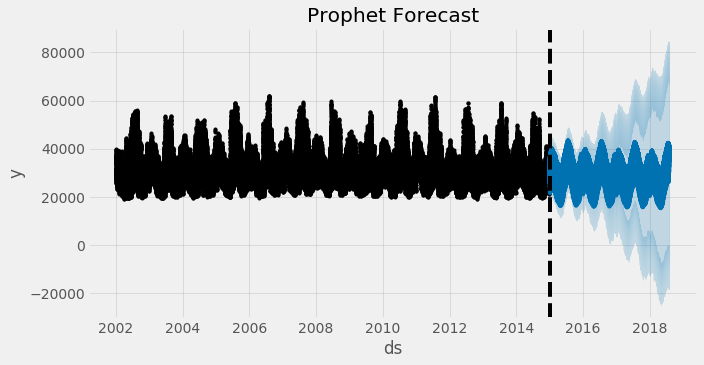

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

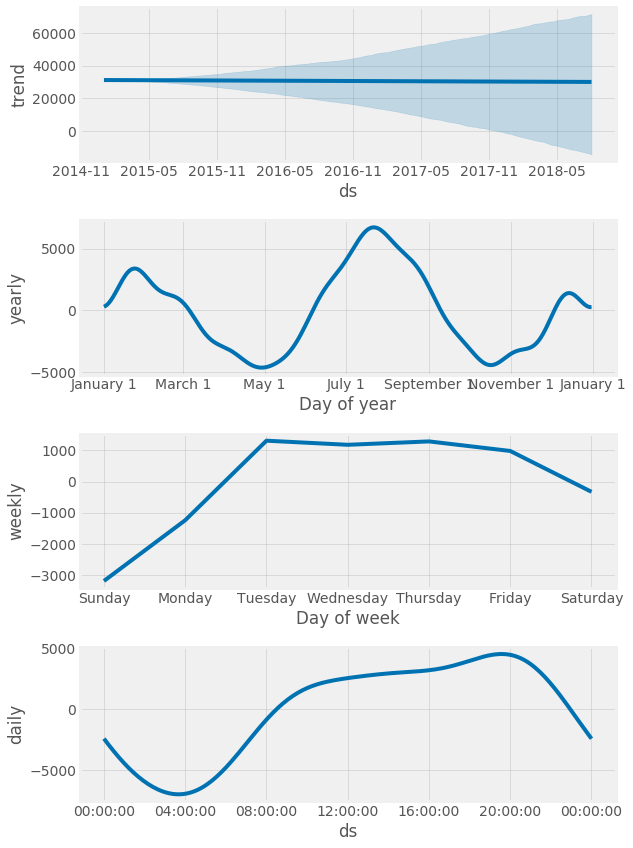

In [29]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

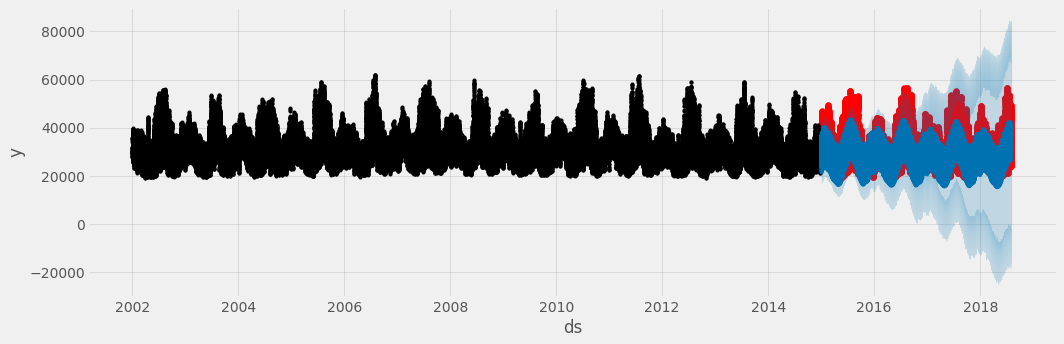

In [31]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

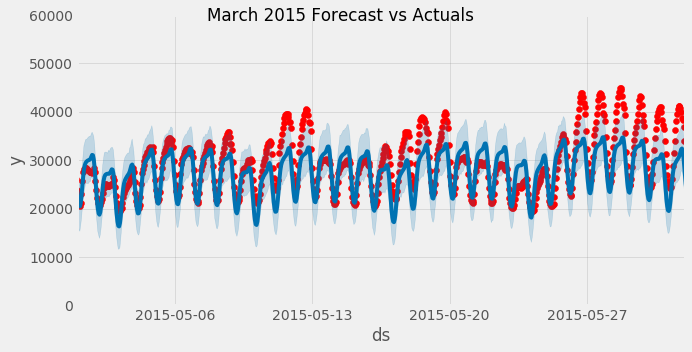

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='05-01-2015',
              upper='06-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('March 2015 Forecast vs Actuals')

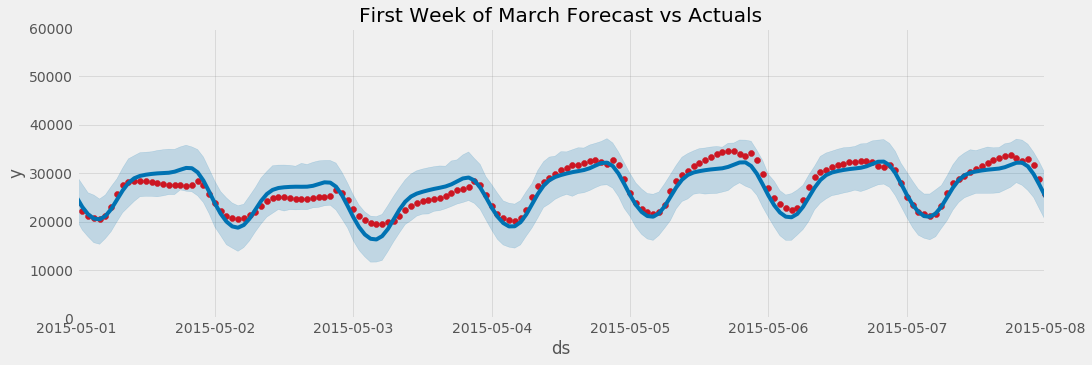

In [33]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='05-01-2015', upper='05-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of March Forecast vs Actuals')
plt.show()

# Evaluate the model with Error Metrics

In [34]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6615.789612716261

In [35]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.435398725501

In [36]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.510098724464633

# Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

I will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [37]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [38]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

CPU times: user 4min, sys: 723 ms, total: 4min 1s
Wall time: 4min


In [39]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

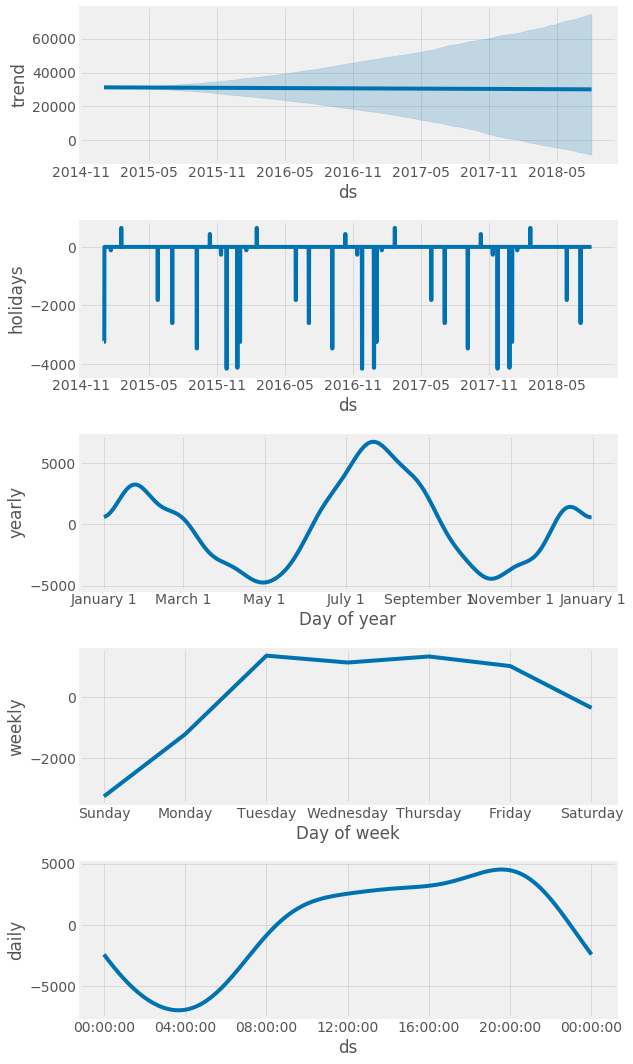

In [40]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

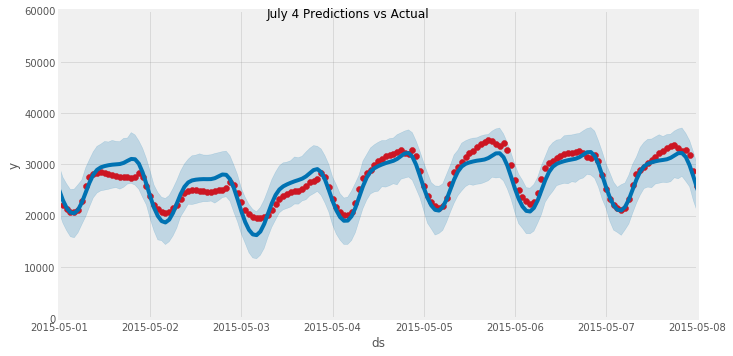

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='05-01-2015',
              upper='05-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('May 4 Predictions vs Actual')

In [41]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6638.130070426887

In [42]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5198.932993297201

In [43]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.566997668611922

# Predict into the Future

We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [44]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [45]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25499.423327
1,2015-01-01 02:00:00,23997.581370
2,2015-01-01 03:00:00,23127.883938
3,2015-01-01 04:00:00,22988.088200
4,2015-01-01 05:00:00,23664.059448


# The End